In [176]:
from warnings import catch_warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=2)

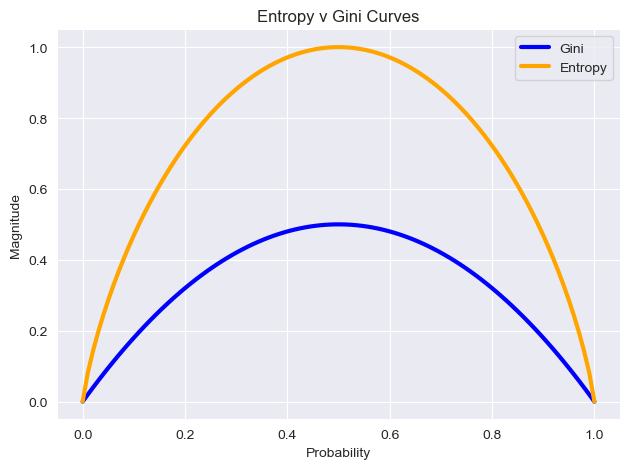

In [255]:
def gini(p):
    return 1 - (p**2 + (1-p)**2)

def entropy(p):
    if p==0:
        return 0
    elif p == 1:
        return 0
    else:
        return -p*np.log2(p) - (1-p)*np.log2(1-p)

def print_auc(models, X_test, y_test):
    for m in models:
        fpr, tpr, thresholds = roc_curve(y_test, models[m][0].predict_proba(X_test)[:, 1])
        a = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC of {models[m][1]}= {a:.4g}')
    plt.plot([0, 1], [0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
probs = np.linspace(0, 1, 100)

gini_vals = gini(probs)

entropy_vals = [entropy(i) for i in probs]

plt.plot(probs, gini_vals, color = 'blue', linewidth =3, label='Gini')
plt.plot(probs, entropy_vals , color = 'orange', linewidth = 3, label = 'Entropy')
plt.tight_layout()
plt.xlabel('Probability')
plt.ylabel('Magnitude')
plt.title("Entropy v Gini Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
df = sns.load_dataset('titanic')
df.dropna(how='any', inplace=True)
y = df.iloc[:,0].copy(deep=True)
X = df[['pclass', 'age', 'sibsp', 'parch', 'fare']].copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 5805, stratify = y)

In [95]:
clf = tree.DecisionTreeClassifier(random_state=5805).fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
clf_train_score = clf.score(X_train, y_train)
print(f'The score on the training set is {clf_train_score}\nthe score on the test set is {clf_score}')
print(f'The params are {clf.get_params()}')
print(f'Given that the accuracy of the train set is 1, and there is a significant dropoff to the test set - there is a strong indication that the tree is severely overfitting to the training data.')

The score on the training set is 1.0
the score on the test set is 0.6486486486486487
The params are {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 5805, 'splitter': 'best'}


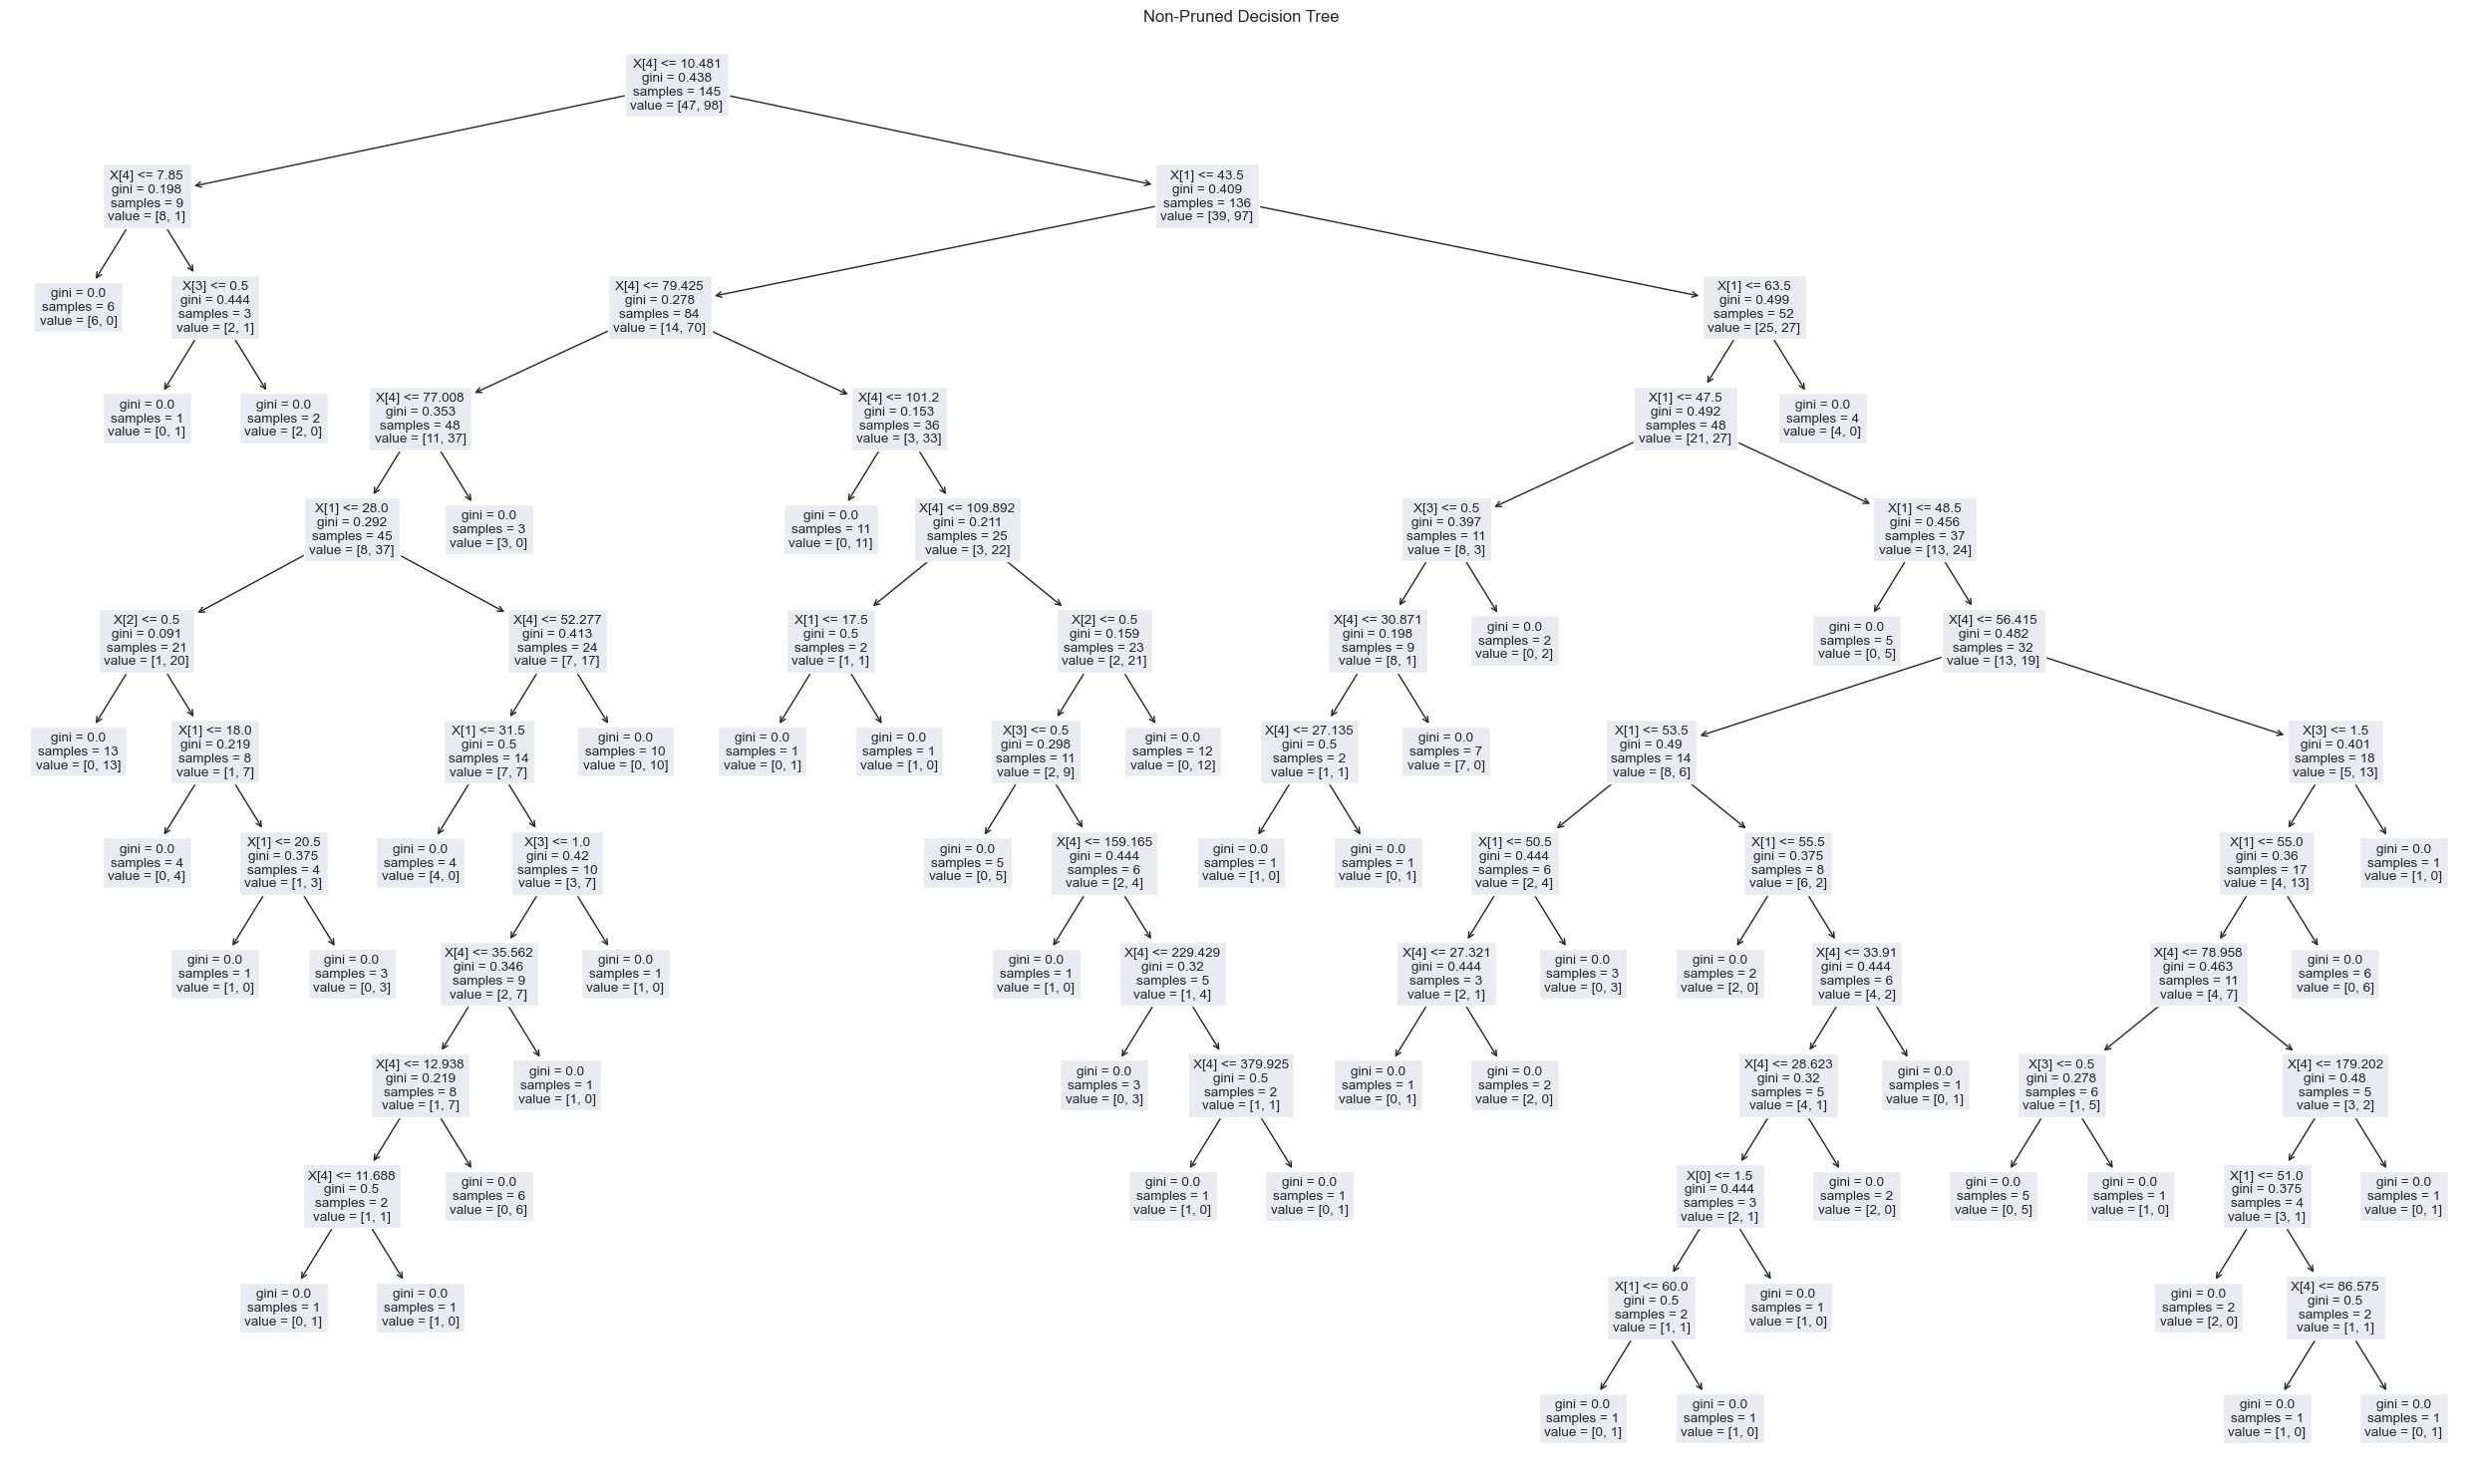

In [257]:
plt.figure(figsize = (25,15))
tree.plot_tree(clf)
plt.title("Non-Pruned Decision Tree")
plt.tight_layout()
plt.show()

In [131]:
pipeline = make_pipeline(tree.DecisionTreeClassifier())
tuned_parameters = [{'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5],
                     'decisiontreeclassifier__min_samples_split': [20,30,40],
                     'decisiontreeclassifier__min_samples_leaf': [10,20,30],
                     'decisiontreeclassifier__criterion':['gini','entropy','log_loss'],
                     'decisiontreeclassifier__splitter':['best','random'],
                     'decisiontreeclassifier__max_features':['sqrt','log2'],
                     'decisiontreeclassifier__random_state' : [5805]}]
grid_search = GridSearchCV(pipeline, tuned_parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'decisiontreeclassifier__criterion': ['gini',
                                                                'entropy',
                                                                'log_loss'],
                          'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5],
                          'decisiontreeclassifier__max_features': ['sqrt',
                                                                   'log2'],
                          'decisiontreeclassifier__min_samples_leaf': [10, 20,
                                                                       30],
                          'decisiontreeclassifier__min_samples_split': [20, 30,
                                                                        40],
                          'decisiontreeclassifier__random_state': [5805],
     

The score on the training set is 0.7517241379310344
the score on the test set is 0.7027027027027027
Because the train set and the test set are fairly close, this indicates that the tree is not overfitting and is generalizing reasonably to the test set.
The pre-pruning process did improve the accuracy of the model as well as reduce overfitting as compared to the no-pruned tree.
The params are {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'random_state': 5805, 'splitter': 'best'}


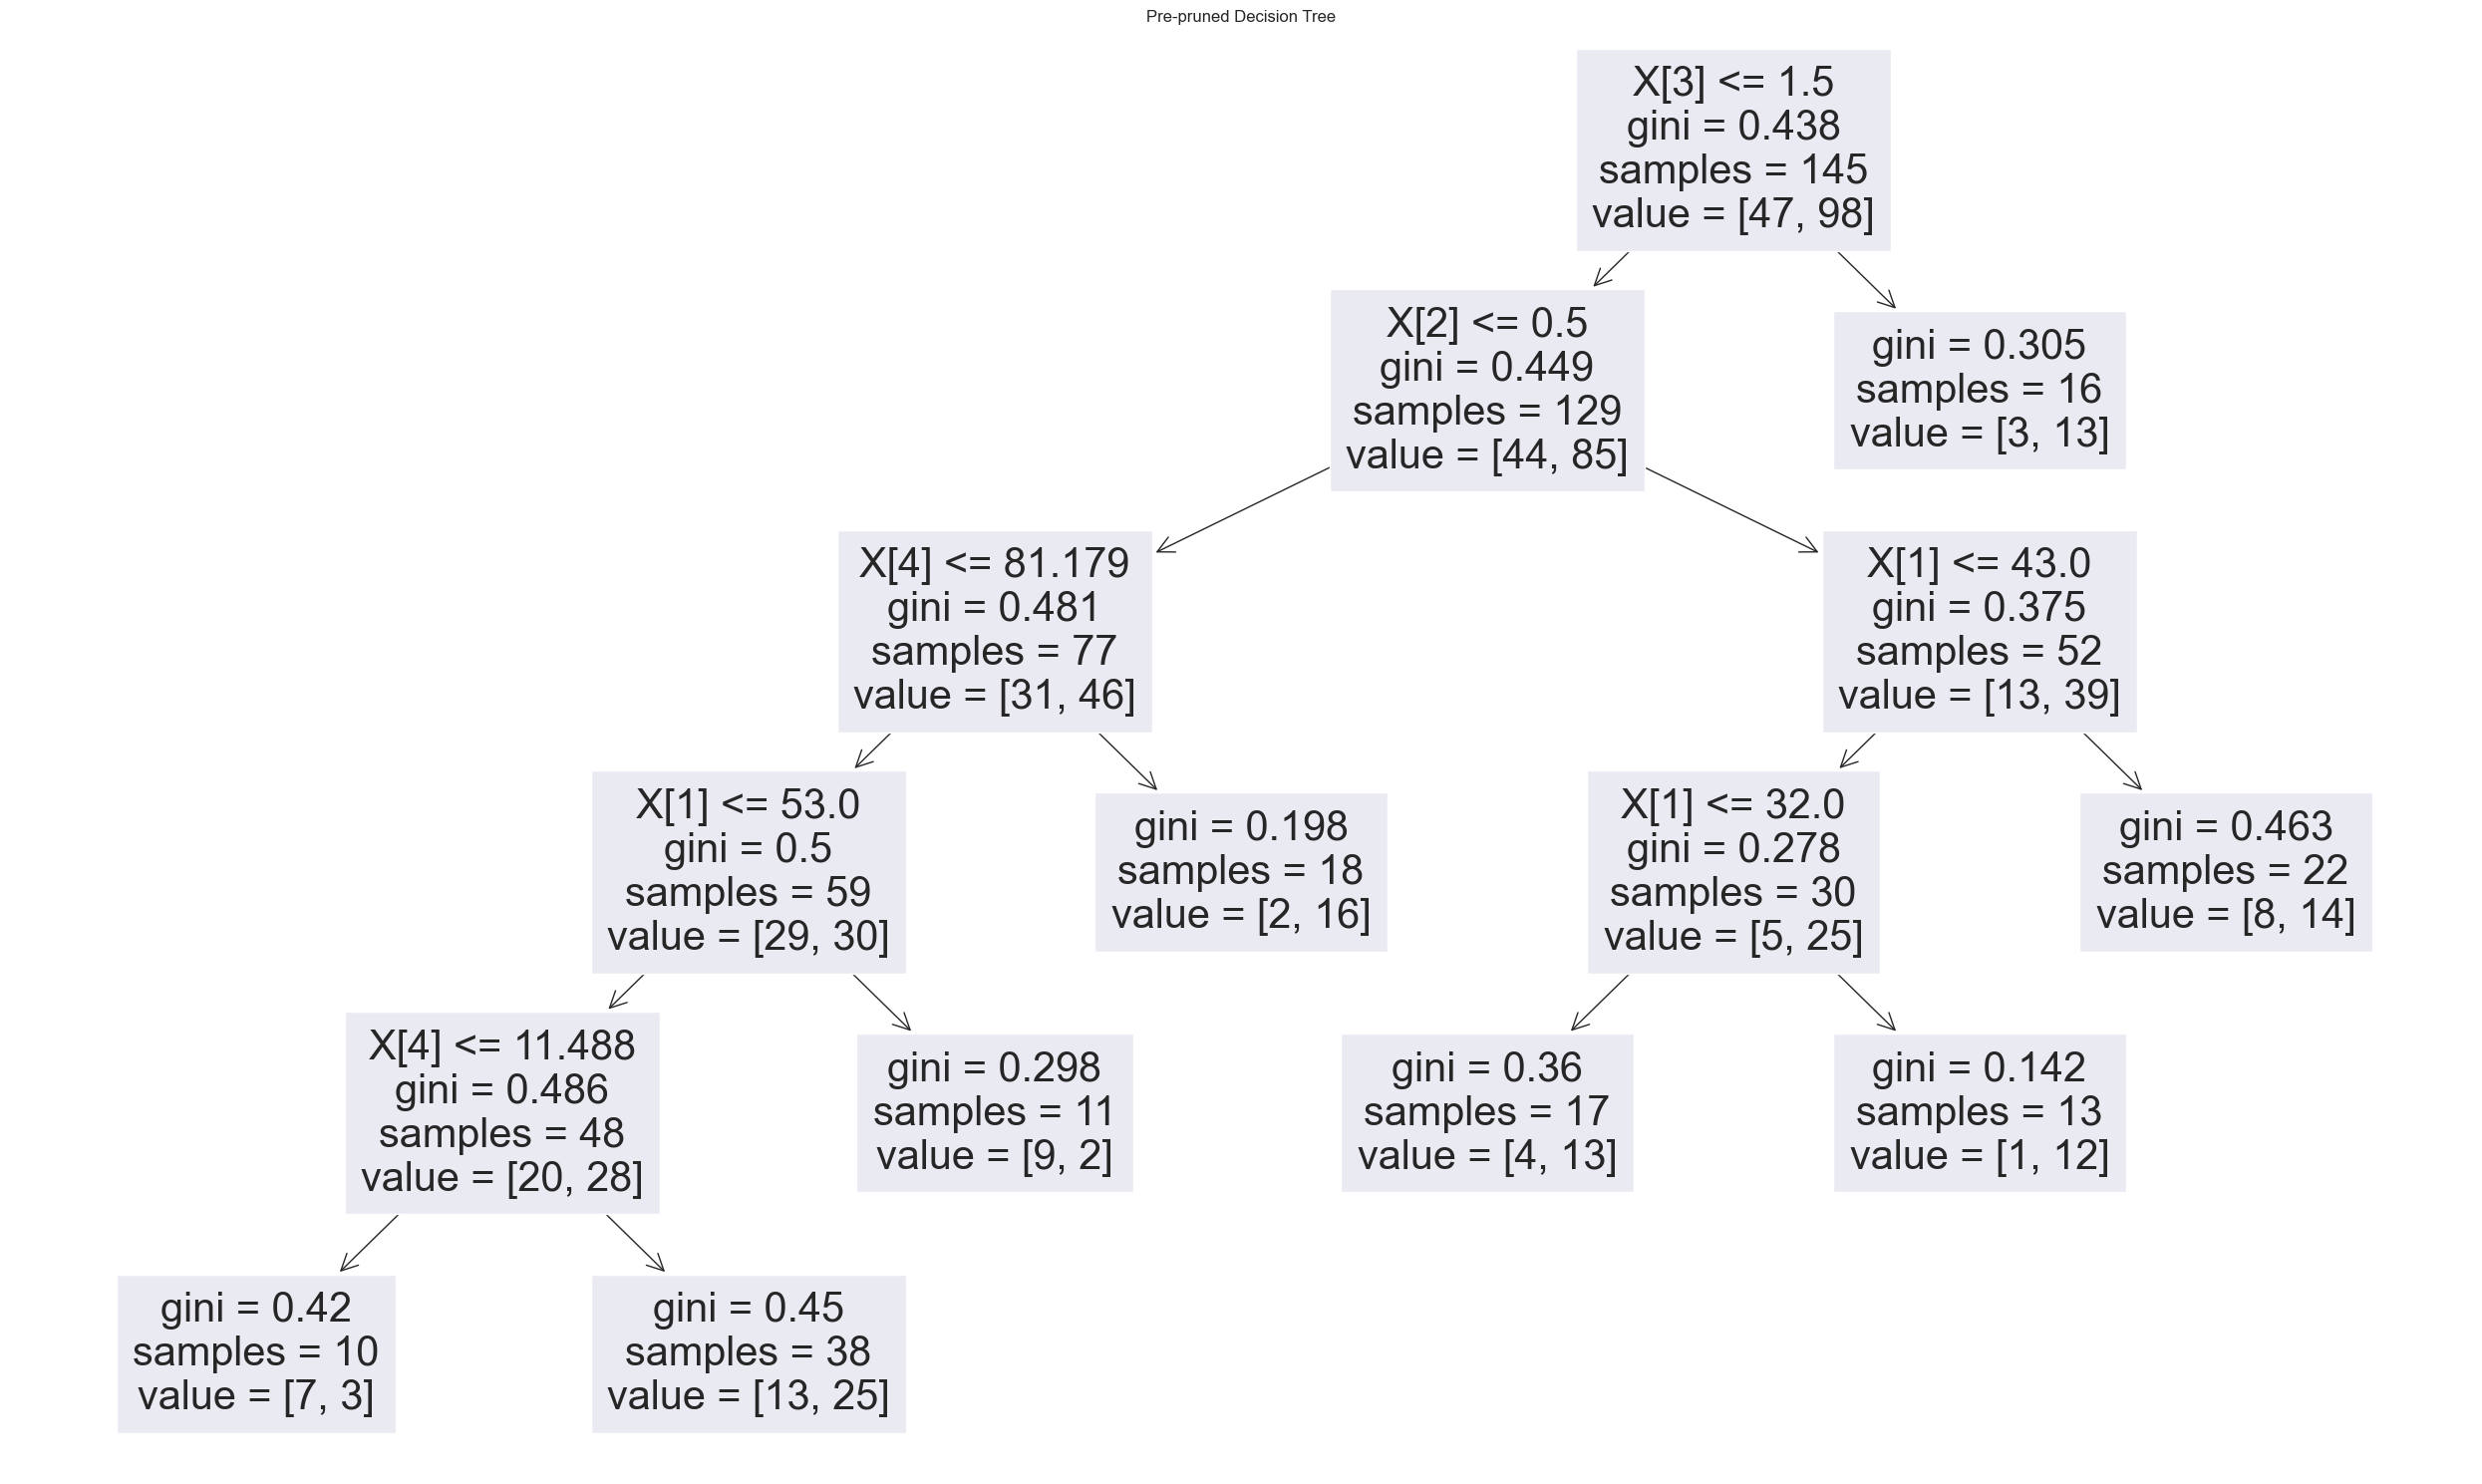

In [256]:
clf2 = grid_search.best_estimator_.named_steps['decisiontreeclassifier']
clf2_score = clf2.score(X_test, y_test)
clf2_train_score = clf2.score(X_train, y_train)
print(f'The score on the training set is {clf2_train_score}\nthe score on the test set is {clf2_score}\nBecause the train set and the test set are fairly close, this indicates that the tree is not overfitting and is generalizing reasonably to the test set.'
      f'\nThe pre-pruning process did improve the accuracy of the model as well as reduce overfitting as compared to the no-pruned tree.')
print(f'The params are {clf2.get_params()}')
plt.figure(figsize = (25,15))
tree.plot_tree(clf2)
plt.title("Pre-pruned Decision Tree")
plt.tight_layout()
plt.show()

In [133]:
print(f'The params for the no-pruned tree are:\n{clf.get_params()}\nand the params for the pre-pruned tree are:\n{clf2.get_params()}')

The params are for the first decision tree are:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 5805, 'splitter': 'best'}
and the params for the second are:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'random_state': 5805, 'splitter': 'best'}


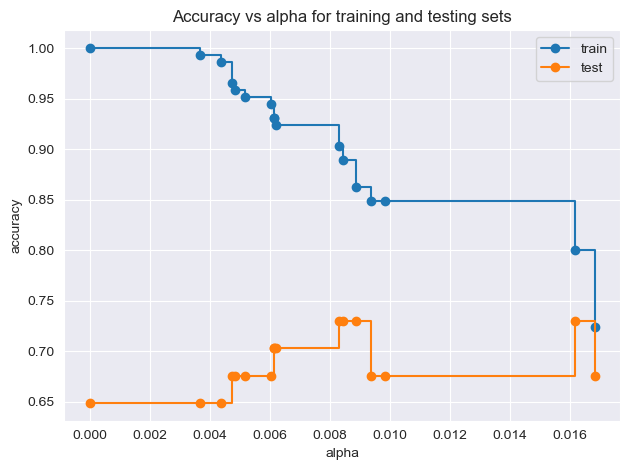

In [258]:
#this was sourced directly from sklearn documentation on post complexity pruning: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
#some code for testing alpha derived from: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
clf3 = tree.DecisionTreeClassifier(random_state=5805)
path = clf3.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]
trees = []
#run the alpha on multiple fitted trees on the training set, and find the value that maximizes the test sit while minimizes overfitting.
for ccp_alpha in ccp_alphas:
    t = tree.DecisionTreeClassifier(random_state = 5805, ccp_alpha = ccp_alpha)
    t.fit(X_train, y_train)
    trees.append(t)
t_train_scores = [t.score(X_train, y_train) for t in trees]
t_test_scores = [t.score(X_test, y_test) for t in trees]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, t_train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, t_test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.xticks(np.arange(0.000, np.max(ccp_alphas), .002))
plt.grid(True)
plt.tight_layout()
plt.show()

The Score for the best alpha of 0.0085 on the train set is:
0.8896551724137931
and the best score on the test set is:
0.7297297297297297
Given that the no-pruned tree scored: 0.6486486486486487 and the pre-pruned tree scored: 0.7027027027027027, we can see that the post-pruned tree had the highest accuracy with: 0.7297297297297297 while also avoiding overfitting.


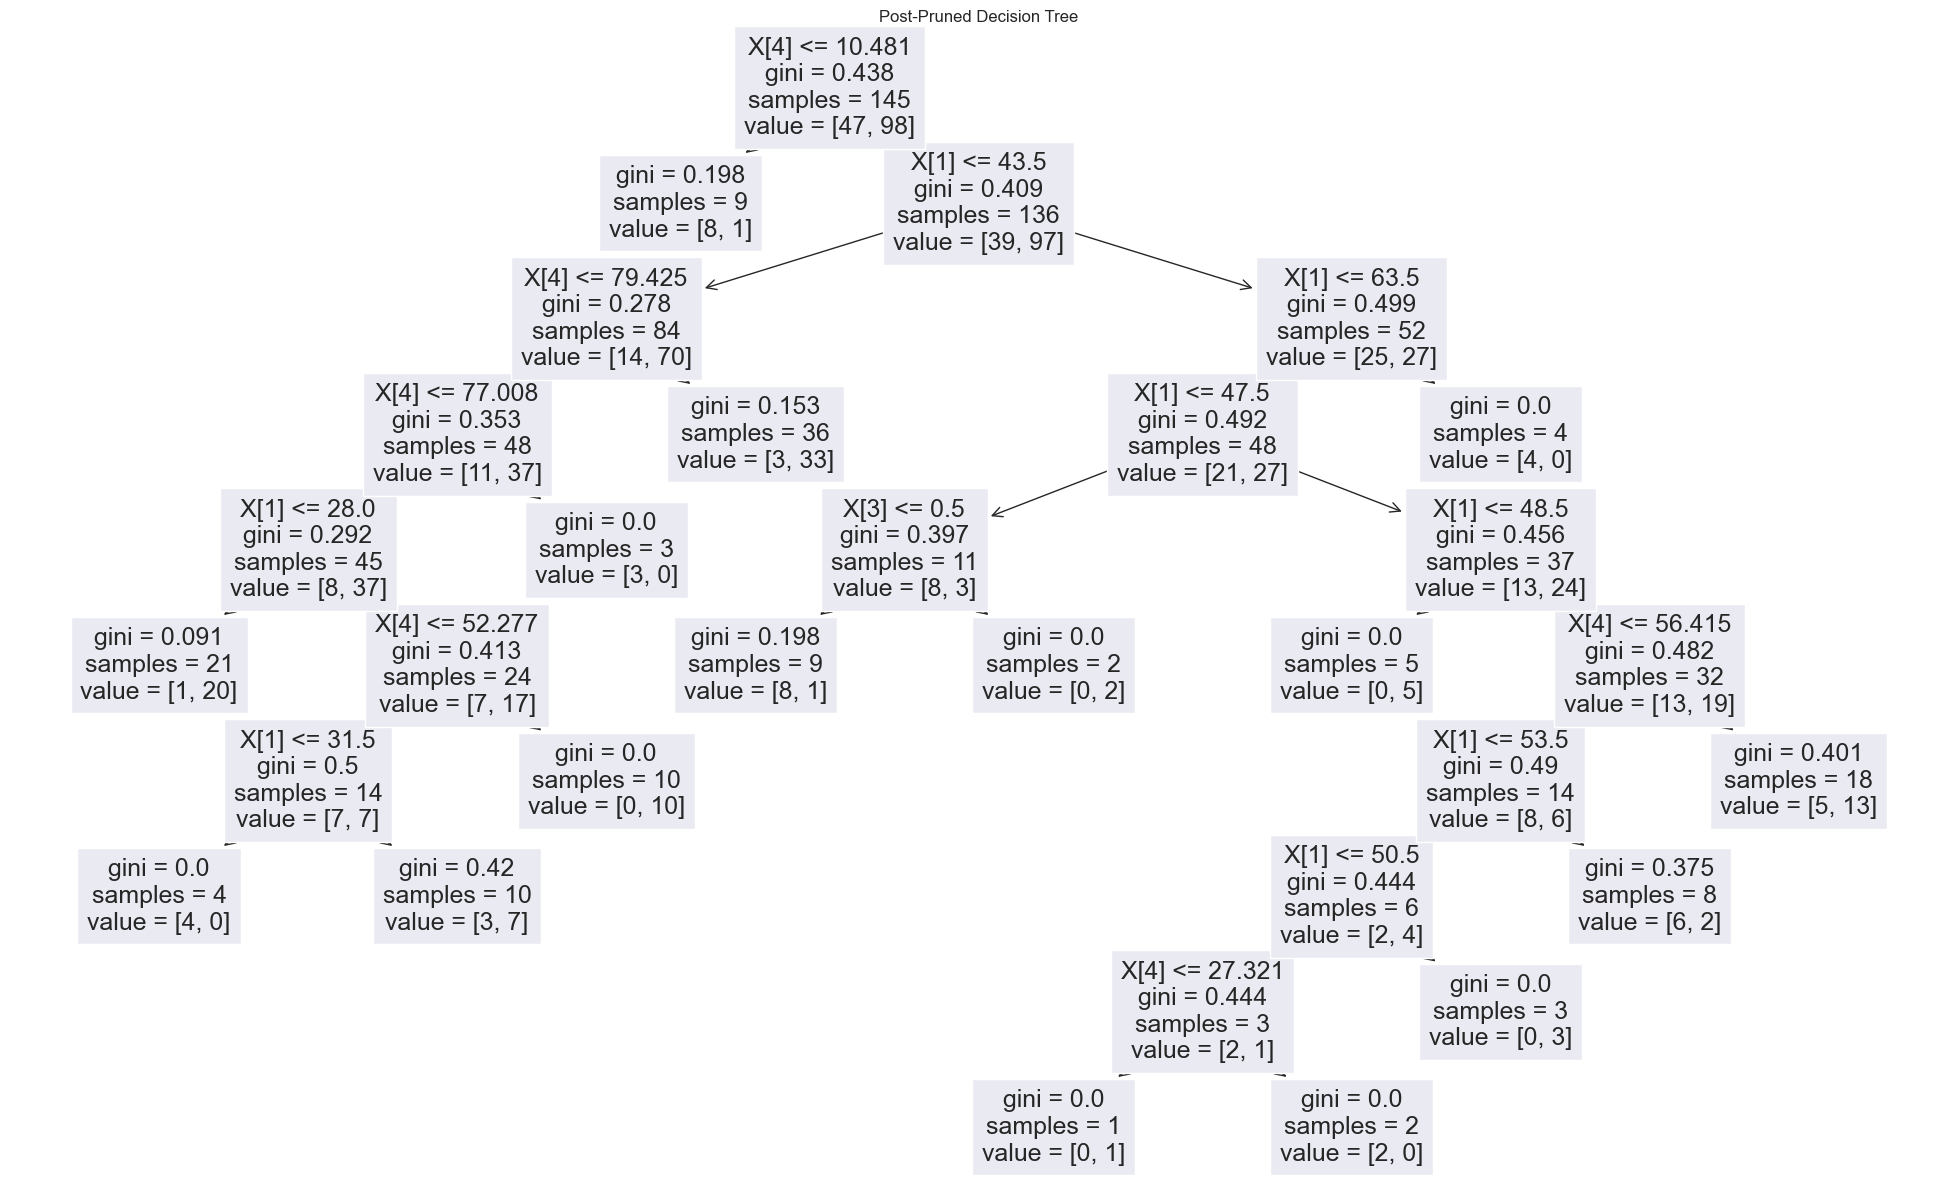

In [260]:
best_ccp = .0085
alpha_tree = tree.DecisionTreeClassifier(random_state = 5805, ccp_alpha=best_ccp).fit(X_train, y_train)
a_score = alpha_tree.score(X_test, y_test)
print(f'The Score for the best alpha of {best_ccp} on the train set is:\n{alpha_tree.score(X_train, y_train)}\nand the best score on the test set is:\n{a_score}')
print(f'Given that the no-pruned tree scored: {clf_score} and the pre-pruned tree scored: {clf2_score}, we can see that the post-pruned tree had the highest accuracy with: {a_score} while also avoiding overfitting.')
plt.figure(figsize = (25,15))
tree.plot_tree(alpha_tree)
plt.title("Post-Pruned Decision Tree")
plt.show()

In [237]:
lr = LogisticRegression(random_state=5805).fit(X_train, y_train)
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)
print(f'The accuracy of the logistic regression train set is: {lr_train_score}\nThe accuracy over the test set is: {lr_test_score}\nIn this circumstance, it seems the post-pruned tree performed the best of all of the classifiers (given that this was just the default state for LR)')

The accuracy of the logistic regression train set is: 0.7241379310344828
The accuracy over the test set is: 0.6756756756756757
In this circumstance, it seems the post-pruned tree performed the best of all of the classifiers (given that this was just the default state for LR)


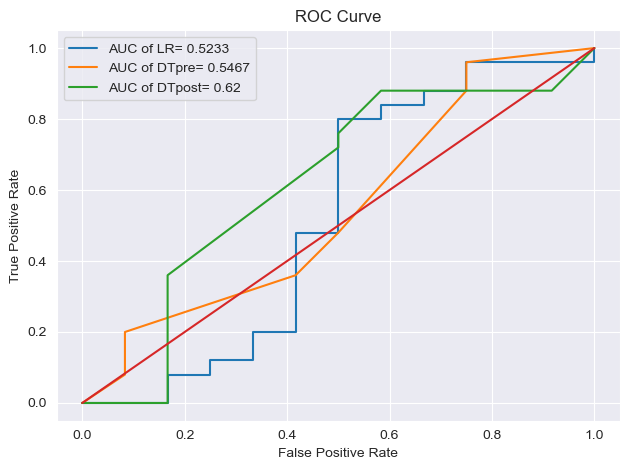

In [238]:
mods = {
    'lr': [lr, 'LR'],
    'pre': [clf2, 'DTpre'],
    'post': [alpha_tree, 'DTpost']
}

print_auc(mods, X_test, y_test)


In [239]:
def print_confusion_matrix(models, X_test, y_test):
    for m in models:
        cm = confusion_matrix(y_test, models[m][0].predict(X_test))
        disp = ConfusionMatrixDisplay(confusion_matrix = cm ,display_labels = models[m][0].classes_)
        disp.plot(cmap = plt.cm.Blues)
        plt.title(f'Confusion matrix for the {models[m][1]} model')
        plt.show()
        print(f'Non Graphical form of the confusion matrix:\n{confusion_matrix(y_test, models[m][0].predict(X_test))}')

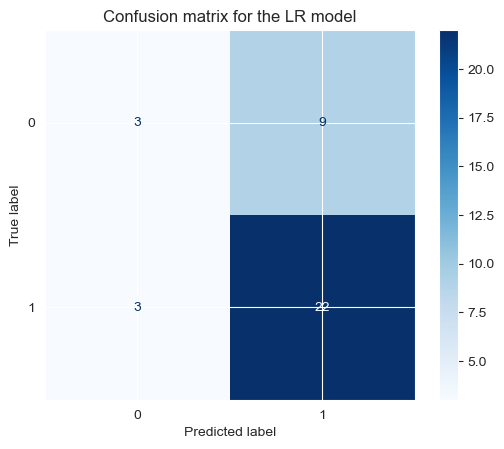

Non Graphical form of the confusion matrix:
[[ 3  9]
 [ 3 22]]


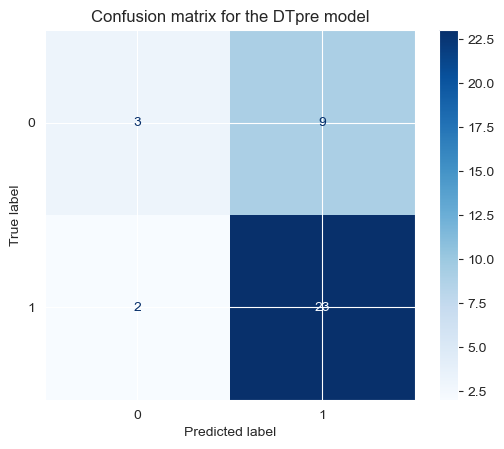

Non Graphical form of the confusion matrix:
[[ 3  9]
 [ 2 23]]


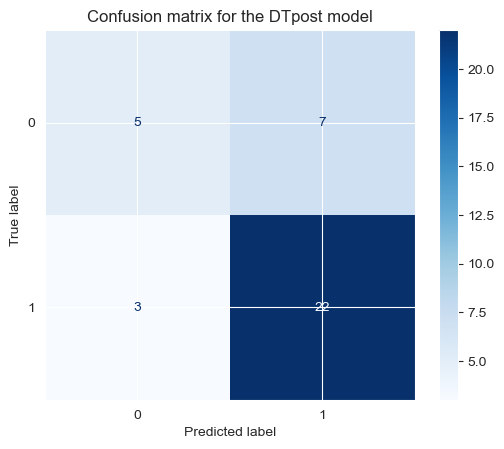

Non Graphical form of the confusion matrix:
[[ 5  7]
 [ 3 22]]


In [240]:
print_confusion_matrix(mods, X_test, y_test)

In [250]:
fpr, tpr, thresholds = roc_curve(y_test, clf2.predict_proba(X_test)[:, 1])
a = auc(fpr, tpr)
pre_prune_model = {
    'Accuracy': accuracy_score(y_test, clf2.predict(X_test)),
    'Recall' : recall_score(y_test, clf2.predict(X_test)),
    'AUC' : a
}
fpr, tpr, thresholds = roc_curve(y_test, alpha_tree.predict_proba(X_test)[:, 1])
a = auc(fpr, tpr)
post_prune_model = {
    'Accuracy': accuracy_score(y_test, alpha_tree.predict(X_test)),
    'Recall' : recall_score(y_test, alpha_tree.predict(X_test)),
    'AUC' : a
}
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
a = auc(fpr, tpr)
LR_model = {
    'Accuracy': accuracy_score(y_test, lr.predict(X_test)),
    'Recall' : recall_score(y_test, lr.predict(X_test)),
    'AUC' : a
}

d = [pre_prune_model, post_prune_model, LR_model]

In [251]:
df2 = pd.DataFrame(d, index = ['pre-prune', 'post-prune', 'logistic_regression'])

In [252]:
print(f'The final table with precision, recall, and AUC score (because the confusion matrices and ROC curve are separate and cannot be included in a table) is:\n{df2.head()}')

The final table with precision, recall, and AUC score (because the confusion matrices and ROC curve are separate and cannot be included in a table) is:
                     Accuracy  Recall       AUC
pre-prune            0.702703    0.92  0.546667
post-prune           0.729730    0.88  0.620000
logistic_regression  0.675676    0.88  0.523333


In [253]:
print("Based on This information, I recommend using the post-pruned curve, as it has high model flexibility due to it only requiring a single hyper-parameter, the highest accruacy, and the highest AUC. Although the recall is not as high, I believe fewer false positives is more important to the model, I believe the other metrics offset this for this dataset and the post pruned model should be used.")

Based on This information, 
